# Classification of Human Blood Cells using Convolutional Neural Networks

For this lab, we use the image set [Human White Blood Cells (BBBC045v1)](https://bbbc.broadinstitute.org/BBBC045) from the Broad Bioimage Benchmark Collection [Ljosa et al., Nature Methods, 2012].

Using fluorescence staining [[Label‐Free Identification of White Blood Cells Using Machine Learning (Nassar et. al)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6767740/)], each blood cell has been classified into one of 5 categories: 
 - **B cells** (lymphocytes),
 - **T cells** (lymphocytes),
 - **eosinophils**,
 - **monocytes**,
 - **neutrophils**.

<img src="illustrations/WhiteBloodCells.png" width="500px" title="Blood cell illustration (Wikipedia)" align="center"/>
<center><i>(Illustration from <a href="https://en.wikipedia.org/wiki/White_blood_cell">Wikipédia</a>)</i></center>

## Brightfield dataset
For this lab, we only kept Brightfield images and cropped them into small grayscale patches of 32x32 pixels:

<img src="illustrations/bloodCells.png" title="Blood cells dataset" align="center"/>

These patches are in the **data/bloodcells_small/** folder, splitted into **testing** and **training** sets. In each set, images are splitted according to their categories:
```
└── data
    └── bloodcells_small
        ├── test
        │   ├── B
        │   ├── T
        │   ├── eosinophil
        │   ├── monocyte
        │   └── neutrophil
        └── train
            ├── B
            ├── T
            ├── eosinophil
            ├── monocyte
            └── neutrophil
```

Our goal is to use convolutional neural networks to automatically classify blood cells into one of the five categories, using only the 32x32 pixels brightfield images.

In [5]:
import numpy as np

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.layers import BatchNormalization, Dropout, Activation, Input

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications import VGG16

model = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(32, 32, 3),
    pooling=None,
    classifier_activation="softmax",
)
#import cnn_helper

58892288/58889256 [==============================] - 3s 0us/step


# Loading the data in generators

We use Keras functions [`ImageDataGenerator`](https://keras.io/api/preprocessing/image/#imagedatagenerator-class) and [`flow_from_directory`](https://keras.io/api/preprocessing/image/#flowfromdirectory-method) to create generators for the training and testing datasets.

In [4]:
# create a data generator
datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True, 
    featurewise_std_normalization=True
)
train_generator = datagen.flow_from_directory(
    # You can also try 'data/mnist/train/' which contains digits of size 28x28
    directory='data/bloodcells_small/train/', 
    # We use categorical classes, which means that classes will be one-hot encoded:
    class_mode='categorical',
    batch_size=8,
    target_size=(32, 32),
    shuffle=False,
    color_mode="grayscale")
test_generator = datagen.flow_from_directory(
    directory='data/bloodcells_small/test/',
    # We use categorical classes, which means that classes will be one-hot encoded:
    class_mode='categorical', 
    batch_size=8,
    target_size=(32, 32),
    shuffle=False,
    color_mode="grayscale")
num_classes = 5
input_shape = 32

FileNotFoundError: [Errno 2] No such file or directory: 'data/bloodcells_small/train/'

In [ ]:
# Uncomment to try on the nmist dataset instead of the bloodcells
'''
# create a data generator
datagen = ImageDataGenerator()

train_generator = datagen.flow_from_directory(
    directory='data/mnist/train/', 
    class_mode='categorical', 
    batch_size=8,
    target_size=(28, 28),
    shuffle=False,
    seed=42,
    color_mode="grayscale")
test_generator = datagen.flow_from_directory(
    directory='data/mnist/test/',
    class_mode='categorical', 
    batch_size=8,
    target_size=(28, 28),
    shuffle=False,
    seed=42,
    color_mode="grayscale")
num_classes = 10
input_shape = 28

print ("Images per class in training:", cnn_helper.getClassSizes(train_generator))
print ("Images per class in testing:", cnn_helper.getClassSizes(test_generator))
'''

In [3]:
print ("Images per class in training:", cnn_helper.getClassSizes(train_generator))
print ("Images per class in testing:", cnn_helper.getClassSizes(test_generator))

Images per class in training: {0: 3430, 1: 3200, 2: 3265, 3: 3346, 4: 3500}
Images per class in testing: {0: 603, 1: 900, 2: 589, 3: 957, 4: 1000}


We can now check that the generators contain our data:

Category (one-hot encoded): [0. 0. 1. 0. 0.]
Image shape: (32, 32)


C:\Users\chrav452\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\Users\chrav452\Anaconda3\lib\site-packages\keras_preprocessing\image\image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


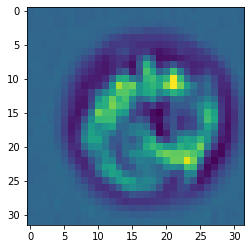

Category (one-hot encoded): [0. 0. 1. 0. 0.]
Image shape: (32, 32)


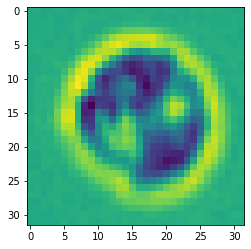

Category (one-hot encoded): [1. 0. 0. 0. 0.]
Image shape: (32, 32)


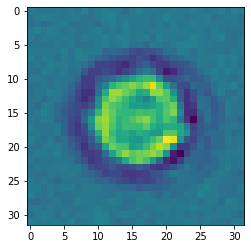

Category (one-hot encoded): [1. 0. 0. 0. 0.]
Image shape: (32, 32)


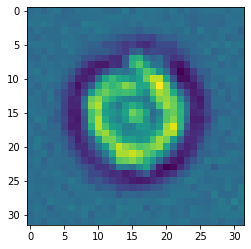

Category (one-hot encoded): [0. 1. 0. 0. 0.]
Image shape: (32, 32)


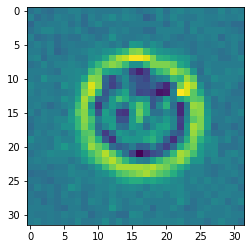

In [4]:
import random
import matplotlib.pyplot as plt

for i in range(5):
    batch_index = random.randrange(len(train_generator))
    images,categories= train_generator[batch_index]
    
    #Images are in the shape 32x32x1 and we need 32x32 to be display, so we squeeze the image:
    image = np.squeeze(images[0])
    
    print ("Category (one-hot encoded):", categories[0])
    print ("Image shape:", image.shape)
    plt.imshow(image)
    plt.show()

# Training the model
## A first CNN model

We can start by building a simple convolutional network with one convolutional layer followed by one max-pooling layer.

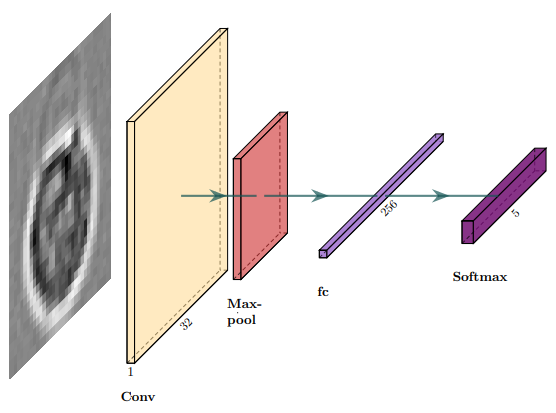

In [5]:
num_filters = 1
filter_size = 2
pool_size = 2

# Build the model.
model = Sequential([
  Conv2D(num_filters, filter_size, input_shape=(input_shape,input_shape,1)),
  MaxPooling2D(pool_size=pool_size),
  Flatten(),
  Dense(num_classes, activation='softmax'),
])

# Compile the model.
model.compile(
  'adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

In [6]:
# Train the model.
model.fit(
  train_generator,
  epochs=3,
  validation_data=test_generator,
)

Epoch 1/3
2093/2093 [==============================] - 11s 5ms/step - loss: 1.3642 - accuracy: 0.4288 - val_loss: 1.2514 - val_accuracy: 0.4823
Epoch 2/3
2093/2093 [==============================] - 11s 5ms/step - loss: 1.0987 - accuracy: 0.5482 - val_loss: 1.1303 - val_accuracy: 0.5448
Epoch 3/3
2093/2093 [==============================] - 11s 5ms/step - loss: 0.9918 - accuracy: 0.5965 - val_loss: 1.0249 - val_accuracy: 0.5878


In [21]:
# get random batch of images
batch_index = random.randrange(len(test_generator))
images, categories = test_generator[batch_index]

# compute predictions for the batch
predictions = model.predict(images)

# display predictions using argmax
print(np.argmax(predictions, axis=1))

# compare predictions with ground truth
print (np.argmax(categories, axis=1))

[0 1 4 1 4 0 1 1]
[1 1 1 1 1 1 1 1]


We can also plot confusion matrix of the whole generator, using the function:
```python
cnn_helper.plot_confusion_matrix_from_generator (model, generator)
```

Test set:
Accuracy: 0.5877994566559644


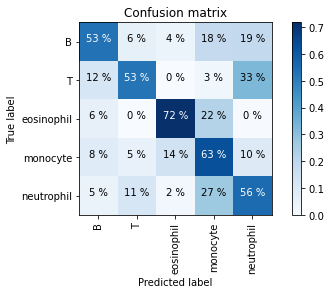

In [22]:
print ("Test set:")
cnn_helper.plot_confusion_matrix_from_generator (model, test_generator)

# Extensions

We can now modify our network to improve the accuracy of our classification. 

### Network depth
You can add more convolutional and max-pooling layers, and change the number of features in each convolutional layer.

For example, here are two iterations of convolutional layer plus max-pooling, with 16 and 32 features respectively, and a kernel size of 3:
```Python
model = Sequential([
    Conv2D(16, kernel_size=3, input_shape=(input_shape,input_shape,1)),
    MaxPooling2D(pool_size=2),
    Conv2D(32, kernel_size=3),
    MaxPooling2D(pool_size=2),
    [...]
])
```

### Dropout
Dropout layers can prevent overfitting. You can add dropout layers after max-pooling. A dropout of 20% is a good starting point.

```Python
model = Sequential([
    [...]
    Dropout(0.2),
    [...]
])
```

### Fully-connected Layers

Most CNNs use multiple fully-connected layers before the final softmax layer. You can add fully-connected layers using:

```Python
model = Sequential([
    [...]
    Dense(64, activation='relu'),
    [...]
])
```

### Convolution Parameters

Try to add an activation function to the convelutional layers (`activation='relu'`), and play with other parameters such as `strides` and `padding` (see details [here](https://keras.io/api/layers/convolution_layers/convolution2d/)).

```Python
model = Sequential([
    [...]
    Conv2D(
        num_filters,
        filter_size,
        input_shape=(32, 32, 1),
        strides=2,
        padding='same',
        activation='relu',
    ),
    [...]
])
```
 
### Example of more advanced convolutional neural network:
![image.png](attachment:image.png)

In [23]:
num_filters = 16
# Create the model
model = Sequential([
    Conv2D(num_filters, kernel_size=(3, 3), activation='relu', input_shape=(input_shape,input_shape,1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    Conv2D(num_filters*2, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    Flatten(),
    Dense(num_filters*8, activation='relu'),
    Dense(num_classes, activation='softmax'),
])

# Compile the model.
model.compile(
  optimizer = Adam(learning_rate=0.0001),
  loss      = 'categorical_crossentropy',
  metrics   = ['accuracy'],
)

In [24]:
# Train the model.
model.fit(
  train_generator,
  epochs=5,
  validation_data=test_generator,
  class_weight=cnn_helper.getClassWeights(train_generator)
)

Epoch 1/5
2093/2093 [==============================] - 21s 10ms/step - loss: 1.0848 - accuracy: 0.5691 - val_loss: 0.8425 - val_accuracy: 0.6651
Epoch 2/5
2093/2093 [==============================] - 26s 12ms/step - loss: 0.6394 - accuracy: 0.7668 - val_loss: 0.6752 - val_accuracy: 0.7424
Epoch 3/5
2093/2093 [==============================] - 29s 14ms/step - loss: 0.4898 - accuracy: 0.8265 - val_loss: 0.5565 - val_accuracy: 0.7925
Epoch 4/5
2093/2093 [==============================] - 24s 11ms/step - loss: 0.4082 - accuracy: 0.8582 - val_loss: 0.4258 - val_accuracy: 0.8518
Epoch 5/5
2093/2093 [==============================] - 30s 14ms/step - loss: 0.3529 - accuracy: 0.8770 - val_loss: 0.3897 - val_accuracy: 0.8666


Test set:
Accuracy: 0.8666337367251173


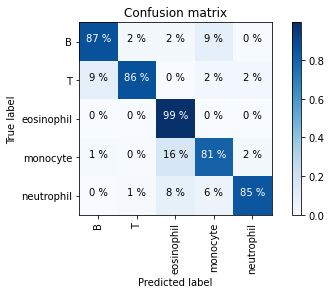

In [25]:
#print ("Train set:")
#cnn_helper.plot_confusion_matrix_from_generator (model, train_generator)

print ("Test set:")
cnn_helper.plot_confusion_matrix_from_generator (model, test_generator)

# Example of transfer learning from ImageNet, using a VGG16 network

This needs to be run on a GPU. See with Claudio?

VGG16 is a Convolutional Neural Network with five convolutional layers followed by three fully connected layers:

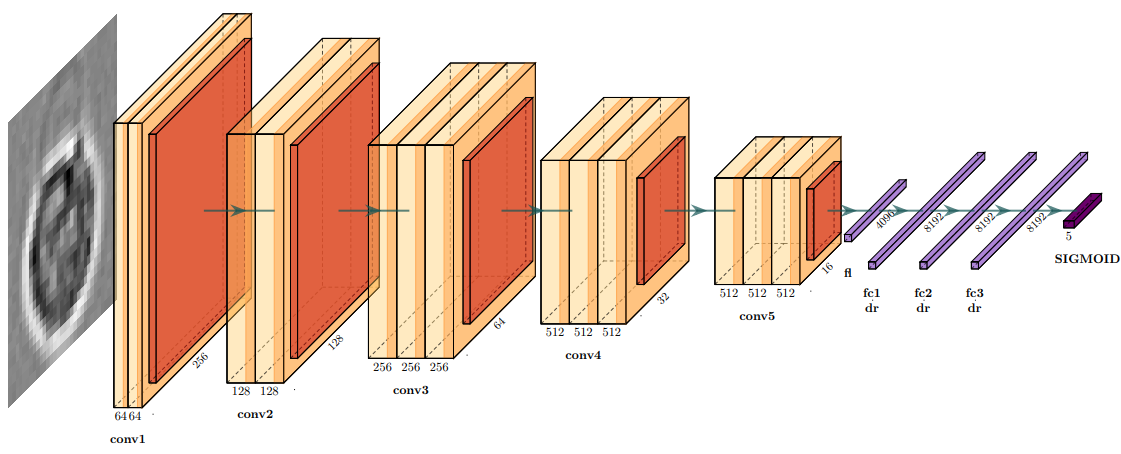

We need to load data in RGB color mode, as VGG16 expects input with 3 layers:

In [3]:
# create a data generator
train_generator_vgg = datagen.flow_from_directory(
    directory='data/bloodcells_small/train/', 
    class_mode='categorical', 
    batch_size=8,
    target_size=(32, 32),
    shuffle=False,
    color_mode="rgb")
test_generator_vgg = datagen.flow_from_directory(
    directory='data/bloodcells_small/test/',
    class_mode='categorical', 
    batch_size=8,
    target_size=(32, 32),
    shuffle=False,
    color_mode="rgb")

NameError: name 'datagen' is not defined

In [ ]:
from tensorflow.keras.applications import VGG16

model = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(32, 32, 3),
    pooling=None,
    classifier_activation="softmax",
)

#for layer in model.layers[:16]:
#    layer.trainable = False
    
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(5, activation='softmax')(class1)
# define new model
model = Model(inputs=model.inputs, outputs=output)


# Compile the model.
model.compile(
  optimizer = Adam(learning_rate=0.000001),
  loss      = 'categorical_crossentropy',
  metrics   = ['accuracy'],
)

model.fit(
  train_generator_vgg,
  epochs=30,
  validation_data=test_generator_vgg,
  class_weight=cnn_helper.getClassWeights(train_generator),
  #use_multiprocessing=True,
  #workers=48
)

Epoch 1/30
1898/2093 [==========================>...] - ETA: 1:33 - loss: 1.0002 - accuracy: 0.6427

In [ ]:
print ("Train set:")
cnn_helper.plot_confusion_matrix_from_generator (model, train_generator_vgg)

print ("Test set:")
cnn_helper.plot_confusion_matrix_from_generator (model, test_generator_vgg)